# Spark Funds Investment Analysis#

**The CEO of Spark Funds wants to understand the global trends in investments so that she can take the investment decisions effectively.**

# Business  Understanding###

Spark Funds has two minor constraints for investments:
1. It wants to invest between 5 to 15 million USD per round of investment
2. It wants to invest only in English-speaking countries because of the ease of communication with the companies it would invest in

# Objective of Study

The objective is to identify the best sectors, countries, and a suitable investment type for making investments. The overall strategy is to invest where others are investing, implying that the 'best' sectors and countries are the ones 'where most investors are investing'.

In [1]:
# Import the packages as required
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

Let's first see the encoding of the files using chardet package. Chardset returns the most appropriate encoding, but it may not hold TRUE also.

*NOTE: This may take a few minutes since we are going to read all data in binary and then invoking chardet*

In [2]:
import chardet as cd
rawdata = open('companies.txt', 'rb').read()
result = cd.detect(rawdata)
result['encoding']

'Windows-1254'

In [3]:
rawdata = open('rounds2.csv', 'rb').read()
result = cd.detect(rawdata)
result['encoding']

'Windows-1254'

Though chardet returns 'Windows-1254' as encoding for both the files, opening with encoding as 'Windows-1254' results in "parse error". Hence we will try to open the file by specifying engine parameter as 'python' instead of default c-engine. 

In [4]:
# Let's load the companies.txt onto "companies" data frame. 
# Here it is assumed that the data files are present in the same folder as the notebook

companies = pd.read_csv("companies.txt", sep="\t", engine = 'python')
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [5]:
# Read the rounds2.csv onto the companies data frame. 
# Here it is assumed that the csv is present in the same folder as the notebook

rounds2 = pd.read_csv('rounds2.csv', engine = 'python')
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.00
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.00
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.00


Let us have a closer looks at these data.

In [6]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
permalink        66368 non-null object
name             66367 non-null object
homepage_url     61310 non-null object
category_list    63220 non-null object
status           66368 non-null object
country_code     59410 non-null object
state_code       57821 non-null object
region           58338 non-null object
city             58340 non-null object
founded_at       51147 non-null object
dtypes: object(10)
memory usage: 5.1+ MB


In [7]:
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Viva-Vision,Peach,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [8]:
rounds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [9]:
rounds2.describe()

,raised_amount_usd
count,94959.00
mean,10426869.33
std,114821247.98
min,0.00
25%,322500.00
50%,1680511.00
75%,7000000.00
max,21271935000.00


Before proceeding further let us convert the permalink id in both the dataframe to lower case.

In [10]:
#Will convert the permalink to lower case as this DF needs to be merged with rounds2 DF down the line in this analsysis.
companies["permalink"] = companies.permalink.str.lower()

In [11]:
#Will convert the company_permalink to lower case as we can see some entries are upper case where as some are lowercase.
rounds2["company_permalink"] = rounds2.company_permalink.str.lower()

**Number of unique companies present in companies dataframe**

It is already mentioned in the description that permalink will be the unique identification for companies. Let's confirm this by printing the number of unique permalink ids from companies dataframe. This should be same as the length of companies dataframe.

In [12]:
unique_companies_compdf = companies.permalink.nunique()
if(len(companies) == unique_companies_compdf) :
    print("permalink is confirmed to be the unique identification for companies")

print("Number of unique companies in companies data frame: ", unique_companies_compdf)

permalink is confirmed to be the unique identification for companies
Number of unique companies in companies data frame:  66368


**Number of unique companies present in round2 dataframe**

In [13]:
unique_companies_rndsdf = rounds2.company_permalink.nunique()
print("Number of unique companies in rounds2 data frame: ", unique_companies_rndsdf)

Number of unique companies in rounds2 data frame:  66368


Though the number of unique companies in companies DF and rounds2 DF are same, still the companies can be different. Let's find out is there are any differences.

**Companies which are only present in "companies" DF**

In [14]:
uniqe_in_companies = set(companies['permalink']) - (set(rounds2['company_permalink']))
print("Number of companies which are only present in 'companies'Data Frame: ", len(uniqe_in_companies))

if(len(uniqe_in_companies) > 0):
    print("Companies only present in companies DF are: ", list(uniqe_in_companies))

Number of companies which are only present in 'companies'Data Frame:  0


**Companies which are only present in "rounds2" DF**

In [15]:
uniqe_in_rounds2 = set(rounds2['company_permalink'])-(set(companies['permalink']))
print("Number of companies which are only present in 'rounds2' Data Frame: ", len(uniqe_in_rounds2))

if(len(uniqe_in_rounds2) > 0):
    print("Companies only present in rounds2 DF are: ", list(uniqe_in_rounds2))

Number of companies which are only present in 'rounds2' Data Frame:  0


*Since the difference above returned empty set there are no new companies in rounds2.*

# Merging Companies dataframe onto rounds2

As per the above observation the unique set of companies in rounds2 and companies data frame are same. So doing an inner merge or left merge both will yield same result. Lets do a left merge as in the assignnment it is mentioned to merge all columns of companies to rounds2.

In [16]:
master_frame = pd.merge(rounds2, companies, how = 'left', left_on='company_permalink',right_on='permalink')
master_frame.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.00,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.00,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.00,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007


In [17]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 16 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
permalink                  114949 non-null object
name                       114948 non-null object
homepage_url               108815 non-null object
category_list              111539 non-null object
status                     114949 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94428 non-null object
dtypes: float64(1), object(15)
memory usage: 14.9+ MB


In [18]:
master_frame.isnull().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
permalink                      0
name                           1
homepage_url                6134
category_list               3410
status                         0
country_code                8678
state_code                 10946
region                     10167
city                       10164
founded_at                 20521
dtype: int64

In [19]:
print("Number of rows present in the master_frame: ", len(master_frame))

Number of rows present in the master_frame:  114949


# Data CLeanup and Preperation

Lets us first remove the columns which are not useful. We need only the following columns 
    1. company_permalink  - Since this is unique identification for comapny
    2. funding_round_type - As part of our analysis we need to see which type of funding is suitable
    3. raised_amount_usd  - funding amount
    4. name               - Retaining name, since it can be used for explanation purpose over company_permalink
    5. category_list      - Category/sector of the business
    6. country_code       - Country 

Please note that deleting the permalink as its duplicate of company_permalink

In [20]:
#master_frame.drop(columns = ['funding_round_permalink', 'funding_round_code', 'funded_at', 'permalink', 'homepage_url', 'status', 'state_code', 'region', 'city', 'founded_at'], inplace = True)
master_frame = master_frame[['company_permalink', 'funding_round_type', 'raised_amount_usd', 'name', 'category_list', 'country_code']]
master_frame.head()

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,country_code
0,/organization/-fame,venture,10000000.00,#fame,Media,IND
1,/organization/-qounter,venture,nan,:Qounter,Application Platforms|Real Time|Social Network...,USA
2,/organization/-qounter,seed,700000.00,:Qounter,Application Platforms|Real Time|Social Network...,USA
3,/organization/-the-one-of-them-inc-,venture,3406878.00,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,NaN
4,/organization/0-6-com,venture,2000000.00,0-6.com,Curated Web,CHN


Next will see how many values are missing per column

In [21]:
master_frame.isnull().sum()

company_permalink         0
funding_round_type        0
raised_amount_usd     19990
name                      1
category_list          3410
country_code           8678
dtype: int64

Will see the percentage of missing data per column

In [22]:
round((master_frame.isnull().sum()/len(master_frame))*100, 2)

company_permalink     0.00
funding_round_type    0.00
raised_amount_usd    17.39
name                  0.00
category_list         2.97
country_code          7.55
dtype: float64

Spark Funds wants to choose one of the four investment types for each potential investment they will make. Considering that Spark Funds wants to invest between 5 to 15 million USD per investment round, need to find out which investment type is the most suitable for it. Also they are interested in investing only in English speaking countries and another ask is to find out the sector where most of investments are done. Given all these, the following 4 columns are directly related:

    1.funding_round_type 

    2.raised_amount_usd

    3.category_list

    4.country_code

From the above analysis it is clear that out of these 4 columns, except *funding_round_type* all other 3 columns has got missing value(Null Values). Also the percentage of missing values within each of these values are less than 20%. In this scnario any kind of the imputation techniques will have direct impact on the analyis. Hence going ahead with removal of the corresponding rows. 

In [23]:
master_frame = master_frame[master_frame.raised_amount_usd.notnull() &
                            master_frame.category_list.notnull() &
                            master_frame.country_code.notnull()]
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88529 entries, 0 to 114947
Data columns (total 6 columns):
company_permalink     88529 non-null object
funding_round_type    88529 non-null object
raised_amount_usd     88529 non-null float64
name                  88528 non-null object
category_list         88529 non-null object
country_code          88529 non-null object
dtypes: float64(1), object(5)
memory usage: 4.7+ MB


In [24]:
round((master_frame.isnull().sum()/len(master_frame))*100, 2)

company_permalink    0.00
funding_round_type   0.00
raised_amount_usd    0.00
name                 0.00
category_list        0.00
country_code         0.00
dtype: float64

**Mean funding in USD based on Funding Type**

Since Spark Fund is only interested in one of the four investment types(venture, angel, seed, and private equity) lets filter the master_frame with only these funding_round_type

In [25]:
list_of_category = ['venture', 'angel', 'seed', 'private_equity']
master_frame = master_frame[master_frame['funding_round_type'].isin(list_of_category)]
master_frame.groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending = False)

funding_round_type
private_equity   73938486.28
venture          11724222.69
angel              971573.89
seed               747793.68
Name: raised_amount_usd, dtype: float64

Plot the average funding amount against the funding round type. 

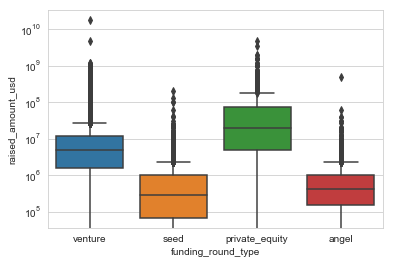

In [26]:
sns.boxplot(x = master_frame['funding_round_type'], y= master_frame['raised_amount_usd'] )
plt.yscale('log')
plt.show()

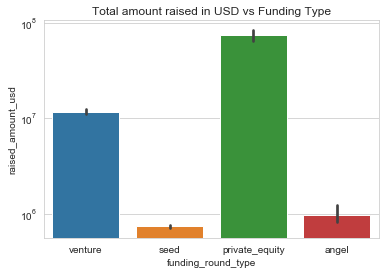

In [27]:
sns.barplot(x = 'funding_round_type', y= 'raised_amount_usd', data = master_frame )
plt.yscale('log')
plt.title('Total amount raised in USD vs Funding Type')
plt.show()

**From the above analysis its clear that "Venture" type is most suitable for Spark Fund since they are considering investment between 5-15M USD**

Filter the master_frame with venture type. Also drop funding_round_type column.

In [28]:
master_frame_venture = master_frame[master_frame['funding_round_type'] == 'venture']
master_frame_venture = master_frame_venture.drop(columns = ['funding_round_type'])
master_frame_venture.describe()

,raised_amount_usd
count,47809.00
mean,11724222.69
std,88215713.61
min,0.00
25%,1600000.00
50%,5000000.00
75%,12000000.00
max,17600000000.00


In [29]:
master_frame_venture.head()

,company_permalink,raised_amount_usd,name,category_list,country_code
0,/organization/-fame,10000000.00,#fame,Media,IND
4,/organization/0-6-com,2000000.00,0-6.com,Curated Web,CHN
8,/organization/0ndine-biomedical-inc,719491.00,Ondine Biomedical Inc.,Biotechnology,CAN
10,/organization/0xdata,20000000.00,H2O.ai,Analytics,USA
11,/organization/0xdata,1700000.00,H2O.ai,Analytics,USA


# Top 9 Countries Based on the funding Received for Venture Funding Type

**To find out Top9 countries based on the amount of funding they received**

Now will explore the funding per Country. Top 9 Countries and the funding amount is printed below

In [30]:
master_frame_venture.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending = False)[:9]

country_code
USA   420068029342.00
CHN    39338918773.00
GBR    20072813004.00
IND    14261508718.00
CAN     9482217668.00
FRA     7226851352.00
ISR     6854350477.00
DEU     6306921981.00
JPN     3167647127.00
Name: raised_amount_usd, dtype: float64

**top9 Dataframe - For the venture investment type, top9 dataframe contains the details of top nine countries (based on the total investment amount each country has received)**

In [31]:
top9 = master_frame_venture[master_frame_venture.country_code.isin(["USA","CHN","GBR","IND","CAN","FRA","ISR","DEU","JPN"])]
top9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44118 entries, 0 to 114941
Data columns (total 5 columns):
company_permalink    44118 non-null object
raised_amount_usd    44118 non-null float64
name                 44118 non-null object
category_list        44118 non-null object
country_code         44118 non-null object
dtypes: float64(1), object(4)
memory usage: 2.0+ MB


In [32]:
top9.head()

,company_permalink,raised_amount_usd,name,category_list,country_code
0,/organization/-fame,10000000.00,#fame,Media,IND
4,/organization/0-6-com,2000000.00,0-6.com,Curated Web,CHN
8,/organization/0ndine-biomedical-inc,719491.00,Ondine Biomedical Inc.,Biotechnology,CAN
10,/organization/0xdata,20000000.00,H2O.ai,Analytics,USA
11,/organization/0xdata,1700000.00,H2O.ai,Analytics,USA


# Top 3 English Speaking Countries based on the Amount of Fuding Received are 1. USA 2.GBR 3.IND

**Extract the primary sector of each category list from the category_list column.**

For some companies, the category list is a list of multiple sub-sectors separated by a pipe (vertical bar |). For example, one of the companies’ category_list is Application Platforms|Real Time|Social Network Media. Business rule is made that the first string before the vertical bar will be considered the primary sector. In the example above, ‘Application Platforms’ will be considered the primary sector. Will create a new column primary_sector as part of the top9 DF, based on the agreed business rule.

In [33]:
top9['primary_sector'] =top9['category_list'].apply(lambda x: x.split('|')[0].lower())

In [34]:
top9.head()

,company_permalink,raised_amount_usd,name,category_list,country_code,primary_sector
0,/organization/-fame,10000000.00,#fame,Media,IND,media
4,/organization/0-6-com,2000000.00,0-6.com,Curated Web,CHN,curated web
8,/organization/0ndine-biomedical-inc,719491.00,Ondine Biomedical Inc.,Biotechnology,CAN,biotechnology
10,/organization/0xdata,20000000.00,H2O.ai,Analytics,USA,analytics
11,/organization/0xdata,1700000.00,H2O.ai,Analytics,USA,analytics


**Use the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors (Note that ‘Others’ is also considered one of the main sectors)**

In [35]:
#Read mapping.csv onto mapping DF. This CSV containst the mapping of category list to either of the 8 sectors.
mapping = pd.read_csv("mapping.csv", engine = 'python')
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [36]:
mapping = mapping.drop(columns = ['Blanks'])
mapping = mapping[mapping.category_list.notnull()]
mapping.head()

,category_list,Automotive & Sports,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
1,3D,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,1,0,0,0,0


In [37]:
# Using melt() method, which is used to un-pivot the data. To map individual sector with master sector will extract the 
# rows with mapping.value same as 1. Once extracted we will delete the value column since we already done with mapping.
# Rename the variable column to main_sector and category_list to primary_sector.

mapping = pd.melt(mapping,id_vars=["category_list"])
mapping = mapping[mapping.value == 1]
mapping = mapping.rename(columns = {'variable':'main_sector', 'category_list':'primary_sector'})
mapping = mapping.drop(columns = ['value'])
mapping.head()

,primary_sector,main_sector
7,Adventure Travel,Automotive & Sports
13,Aerospace,Automotive & Sports
44,Auto,Automotive & Sports
45,Automated Kiosk,Automotive & Sports
46,Automotive,Automotive & Sports


In [38]:
# Convert the primary_sector column to lower case, since we already converted primary_sector columns of top9 DF to lowercase

mapping['primary_sector'] = mapping.primary_sector.str.lower()

Before merging the mapping DF to top9 DF on "primary_sector", explore whether all there are any primary_sector which are only in mappin csv and vice versa.

In [39]:
set(mapping.primary_sector).difference(set(top9.primary_sector))

{'0notechnology',
 '0tural language processing',
 '0tural resources',
 '0vigation',
 'a0lytics',
 'air pollution control',
 'alter0tive medicine',
 'aquaculture',
 'big data a0lytics',
 'biomass power generation',
 'boating industry',
 'building owners',
 'business a0lytics',
 'business travelers',
 'can0bis',
 'career ma0gement',
 'casual games',
 'charities',
 'chi0 internet',
 'cloud ma0gement',
 'cloud-based music',
 'collectibles',
 'contact ma0gement',
 'digital rights ma0gement',
 'digital sig0ge',
 'direct advertising',
 'document ma0gement',
 'educatio0l games',
 'edutainment',
 'email newsletters',
 'energy ma0gement',
 'energy storage',
 'event ma0gement',
 'farmers market',
 'fi0nce',
 'fi0nce technology',
 'fi0ncial exchanges',
 'fi0ncial services',
 'field support services',
 'film distribution',
 'flash sales',
 'fleet ma0gement',
 'flowers',
 'fmcg',
 'forums',
 'fruit',
 'fuel cells',
 'funeral industry',
 'gay & lesbian',
 'general public worldwide',
 'genetic testing

In [40]:
set(top9.primary_sector).difference(set(mapping.primary_sector))

{'adaptive equipment',
 'alternative medicine',
 'analytics',
 'big data analytics',
 'biotechnology and semiconductor',
 'business analytics',
 'cannabis',
 'career management',
 'china internet',
 'cloud management',
 'contact management',
 'digital rights management',
 'digital signage',
 'document management',
 'educational games',
 'energy management',
 'event management',
 'finance',
 'finance technology',
 'financial exchanges',
 'financial services',
 'fleet management',
 'governance',
 'greentech',
 'identity management',
 'innovation management',
 'intellectual asset management',
 'investment management',
 'it management',
 'journalism',
 'knowledge management',
 'lead management',
 'mobile analytics',
 'nanotechnology',
 'natural gas uses',
 'natural language processing',
 'natural resources',
 'navigation',
 'personal finance',
 'personalization',
 'predictive analytics',
 'product search',
 'professional networking',
 'professional services',
 'project management',
 'promo

From the above analysis it is clear that most of the differences are due to mistake in mapping data frame. For example in mapping dataframe 'nanotechnology' is mispelled as '0notechnology' and 'navigation' as 0vigation.

Will correct this using pands.Series.str.replace method. It accepts regex pattern and apply it over each data in the series. Will replace all the '0' with 'na'. But only one exception that dont convert 0 in the pattern 1.0 or 2.0 to na.

In [41]:
#Regex pattern for negative look behind (this will ensure 0s in the 1.0 or 2.0 formats wont be matched)
pat = r"(?<!\.)0"
mapping.primary_sector = mapping.primary_sector.str.replace(pat, 'na', regex=True)

Find out the primary_sector data which are only present in top9. Corresponding rows will be eliminated after merging

In [42]:
set(top9.primary_sector).difference(set(mapping.primary_sector))

{'adaptive equipment',
 'biotechnology and semiconductor',
 'greentech',
 'natural gas uses',
 'product search',
 'racing',
 'rapidly expanding',
 'retirement',
 'specialty retail'}

In [43]:
top9 = top9.merge(mapping, on ='primary_sector')
top9.head()

,company_permalink,raised_amount_usd,name,category_list,country_code,primary_sector,main_sector
0,/organization/-fame,10000000.00,#fame,Media,IND,media,Entertainment
1,/organization/90min,15000000.00,90min,Media|News|Publishing|Soccer|Sports,GBR,media,Entertainment
2,/organization/90min,5800000.00,90min,Media|News|Publishing|Soccer|Sports,GBR,media,Entertainment
3,/organization/90min,18000000.00,90min,Media|News|Publishing|Soccer|Sports,GBR,media,Entertainment
4,/organization/all-def-digital,5000000.00,All Def Digital,Media,USA,media,Entertainment


In [44]:
#Remove category_list columns as the column is no more useful
top9 = top9.drop(columns = ['category_list'])
top9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44107 entries, 0 to 44106
Data columns (total 6 columns):
company_permalink    44107 non-null object
raised_amount_usd    44107 non-null float64
name                 44107 non-null object
country_code         44107 non-null object
primary_sector       44107 non-null object
main_sector          44107 non-null object
dtypes: float64(1), object(5)
memory usage: 2.4+ MB


# Sector Wise Analysis For Top 3 English Speaking Countries

<h3> Creating D1 for USA </h3>

In [45]:
# Dataframe for top english speaking company -USA
# Extract the rows for USA where 5000000>=raised_amount_usd <= 15000000
D1 = top9[(top9['country_code'] == 'USA') & 
          (top9['raised_amount_usd'] >= 5000000) & 
          (top9['raised_amount_usd'] <= 15000000)]

In [46]:
D1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12063 entries, 4 to 44099
Data columns (total 6 columns):
company_permalink    12063 non-null object
raised_amount_usd    12063 non-null float64
name                 12063 non-null object
country_code         12063 non-null object
primary_sector       12063 non-null object
main_sector          12063 non-null object
dtypes: float64(1), object(5)
memory usage: 659.7+ KB


**Count of venture type investments in USA, for rangs 5M>= x <=15M USD is : 12063**

In [47]:
D1.head()

,company_permalink,raised_amount_usd,name,country_code,primary_sector,main_sector
4,/organization/all-def-digital,5000000.00,All Def Digital,USA,media,Entertainment
14,/organization/chefs-feed,5000000.00,ChefsFeed,USA,media,Entertainment
20,/organization/huffingtonpost,5000000.00,The Huffington Post,USA,media,Entertainment
21,/organization/huffingtonpost,5000000.00,The Huffington Post,USA,media,Entertainment
26,/organization/matchmine,10000000.00,MatchMine,USA,media,Entertainment


In [48]:
D1.raised_amount_usd.sum()

107757097294.0

**Total amount of investment (USD) for venture type is: 107757097294.0**

In [49]:
#lets create a category wise tavle for USA.
D1_cat_table = D1.pivot_table( values = 'raised_amount_usd', index = ['main_sector'], aggfunc  = ['count', 'sum'])

In [50]:
#After pivot_table columns will be multi index, flatten it.
D1_cat_table.columns = D1_cat_table.columns.get_level_values(0)
D1_cat_table = D1_cat_table.rename(columns = {'count':'total_number_of_investment', 'sum':'total_amount_invested'})

<h4> Sector Analyis for USA </h4>

In [51]:
D1_cat_table = D1_cat_table.sort_values(by = ['total_number_of_investment'], ascending = False)
D1_cat_table

,total_number_of_investment,total_amount_invested
main_sector,,
Others,2950,26321007002.00
"Social, Finance, Analytics, Advertising",2714,23807376964.00
Cleantech / Semiconductors,2350,21633430822.00
"News, Search and Messaging",1583,13971567428.00
Health,909,8211859357.00
Manufacturing,799,7258553378.00
Entertainment,591,5099197982.00
Automotive & Sports,167,1454104361.00


In [52]:
#Merge the total_number_of_investment and total_amount_invested on to D1 table
D1 = D1.merge(D1_cat_table, on = 'main_sector')

In [53]:
D1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12063 entries, 0 to 12062
Data columns (total 8 columns):
company_permalink             12063 non-null object
raised_amount_usd             12063 non-null float64
name                          12063 non-null object
country_code                  12063 non-null object
primary_sector                12063 non-null object
main_sector                   12063 non-null object
total_number_of_investment    12063 non-null int64
total_amount_invested         12063 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 848.2+ KB


In [54]:
D1.head()

,company_permalink,raised_amount_usd,name,country_code,primary_sector,main_sector,total_number_of_investment,total_amount_invested
0,/organization/all-def-digital,5000000.00,All Def Digital,USA,media,Entertainment,591,5099197982.00
1,/organization/chefs-feed,5000000.00,ChefsFeed,USA,media,Entertainment,591,5099197982.00
2,/organization/huffingtonpost,5000000.00,The Huffington Post,USA,media,Entertainment,591,5099197982.00
3,/organization/huffingtonpost,5000000.00,The Huffington Post,USA,media,Entertainment,591,5099197982.00
4,/organization/matchmine,10000000.00,MatchMine,USA,media,Entertainment,591,5099197982.00


<h3> Creating D2 for GBR </h3>

In [55]:
# Dataframe for second english speaking company -GBR
# Extract the rows for GBR where 5000000>=raised_amount_usd <= 15000000
D2 = top9[(top9['country_code'] == 'GBR') & 
          (top9['raised_amount_usd'] >= 5000000) & 
          (top9['raised_amount_usd'] <= 15000000)]

In [56]:
D2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 1 to 44094
Data columns (total 6 columns):
company_permalink    621 non-null object
raised_amount_usd    621 non-null float64
name                 621 non-null object
country_code         621 non-null object
primary_sector       621 non-null object
main_sector          621 non-null object
dtypes: float64(1), object(5)
memory usage: 34.0+ KB


**Count of venture type investments in GBR, for range 5M>= x <=15M USD is : 621**

In [57]:
D2.head()

,company_permalink,raised_amount_usd,name,country_code,primary_sector,main_sector
1,/organization/90min,15000000.00,90min,GBR,media,Entertainment
2,/organization/90min,5800000.00,90min,GBR,media,Entertainment
114,/organization/azimo,10000000.00,Azimo,GBR,curated web,"News, Search and Messaging"
125,/organization/basekit-platform,7000000.00,BaseKit,GBR,curated web,"News, Search and Messaging"
126,/organization/basekit-platform,6818631.00,BaseKit,GBR,curated web,"News, Search and Messaging"


In [58]:
D2.raised_amount_usd.sum()

5379078691.0

**Total amount of investment (USD) for venture type is: 5379078691.0**

In [59]:
#lets create a category wise tavle for GBR.
D2_cat_table = D2.pivot_table( values = 'raised_amount_usd', index = ['main_sector'], aggfunc  = ['count', 'sum'])

In [60]:
#After pivot_table columns will be multi index, flatten it.
D2_cat_table.columns = D2_cat_table.columns.get_level_values(0)
D2_cat_table = D2_cat_table.rename(columns = {'count':'total_number_of_investment', 'sum':'total_amount_invested'})

<h4> Sector Analysis for GBR</h4>

In [61]:
D2_cat_table = D2_cat_table.sort_values(by = ['total_number_of_investment'], ascending = False)
D2_cat_table

,total_number_of_investment,total_amount_invested
main_sector,,
Others,147,1283624289.00
"Social, Finance, Analytics, Advertising",133,1089404014.00
Cleantech / Semiconductors,130,1163990056.00
"News, Search and Messaging",73,615746235.00
Entertainment,56,482784687.00
Manufacturing,42,361940335.00
Health,24,214537510.00
Automotive & Sports,16,167051565.00


In [62]:
#Merge the total_number_of_investment and total_amount_invested on to D2 table
D2 = D2.merge(D2_cat_table, on = 'main_sector')

In [63]:
D2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 0 to 620
Data columns (total 8 columns):
company_permalink             621 non-null object
raised_amount_usd             621 non-null float64
name                          621 non-null object
country_code                  621 non-null object
primary_sector                621 non-null object
main_sector                   621 non-null object
total_number_of_investment    621 non-null int64
total_amount_invested         621 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 43.7+ KB


In [64]:
D2.head()

,company_permalink,raised_amount_usd,name,country_code,primary_sector,main_sector,total_number_of_investment,total_amount_invested
0,/organization/90min,15000000.00,90min,GBR,media,Entertainment,56,482784687.00
1,/organization/90min,5800000.00,90min,GBR,media,Entertainment,56,482784687.00
2,/organization/eutechnyx,8800000.00,Eutechnyx,GBR,games,Entertainment,56,482784687.00
3,/organization/mind-candy,10000000.00,Mind Candy,GBR,games,Entertainment,56,482784687.00
4,/organization/mind-candy,10860000.00,Mind Candy,GBR,games,Entertainment,56,482784687.00


<h3> Creating D3 for IND </h3>

In [65]:
# Dataframe for second english speaking company -IND
# Extract the rows for IND where 5000000>=raised_amount_usd <= 15000000
D3 = top9[(top9['country_code'] == 'IND') & 
          (top9['raised_amount_usd'] >= 5000000) & 
          (top9['raised_amount_usd'] <= 15000000)]

In [66]:
D3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 43774
Data columns (total 6 columns):
company_permalink    328 non-null object
raised_amount_usd    328 non-null float64
name                 328 non-null object
country_code         328 non-null object
primary_sector       328 non-null object
main_sector          328 non-null object
dtypes: float64(1), object(5)
memory usage: 17.9+ KB


In [67]:
D3.head()

,company_permalink,raised_amount_usd,name,country_code,primary_sector,main_sector
0,/organization/-fame,10000000.00,#fame,IND,media,Entertainment
116,/organization/babajob,10000000.00,Babajob,IND,curated web,"News, Search and Messaging"
138,/organization/bharat-matrimony,11750000.00,Bharat Matrimony,IND,curated web,"News, Search and Messaging"
167,/organization/bluestone-com,5000000.00,Bluestone.com,IND,curated web,"News, Search and Messaging"
169,/organization/bluestone-com,10000000.00,Bluestone.com,IND,curated web,"News, Search and Messaging"


**Total count of venture type funding between 5M to 15 M USD in IND: 328**

In [68]:
D3.raised_amount_usd.sum()

2949543602.0

**Total Amount Raised in USD for venture type funding between 5M to 15M USD in IND: 2949543602.0**

In [69]:
#lets create a category wise tavle for IND.
D3_cat_table = D3.pivot_table( values = 'raised_amount_usd', index = ['main_sector'], aggfunc  = ['count', 'sum'])

In [70]:
#After pivot_table columns will be multi index, flatten it.
D3_cat_table.columns = D3_cat_table.columns.get_level_values(0)
D3_cat_table = D3_cat_table.rename(columns = {'count':'total_number_of_investment', 'sum':'total_amount_invested'})

<h4> Sector Analysis for IND </h4>

In [71]:
D3_cat_table = D3_cat_table.sort_values(by = ['total_number_of_investment'], ascending = False)
D3_cat_table

,total_number_of_investment,total_amount_invested
main_sector,,
Others,110,1013409507.00
"Social, Finance, Analytics, Advertising",60,550549550.00
"News, Search and Messaging",52,433834545.00
Entertainment,33,280830000.00
Manufacturing,21,200900000.00
Cleantech / Semiconductors,20,165380000.00
Health,19,167740000.00
Automotive & Sports,13,136900000.00


In [72]:
#Merge the total_number_of_investment and total_amount_invested on to D2 table
D3 = D3.merge(D3_cat_table, on = 'main_sector')

In [73]:
D3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 0 to 327
Data columns (total 8 columns):
company_permalink             328 non-null object
raised_amount_usd             328 non-null float64
name                          328 non-null object
country_code                  328 non-null object
primary_sector                328 non-null object
main_sector                   328 non-null object
total_number_of_investment    328 non-null int64
total_amount_invested         328 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 23.1+ KB


In [74]:
D3.head()

,company_permalink,raised_amount_usd,name,country_code,primary_sector,main_sector,total_number_of_investment,total_amount_invested
0,/organization/-fame,10000000.00,#fame,IND,media,Entertainment,33,280830000.00
1,/organization/dhruva,5000000.00,Dhruva,IND,games,Entertainment,33,280830000.00
2,/organization/games2win,5000000.00,Games2Win,IND,games,Entertainment,33,280830000.00
3,/organization/games2win,6000000.00,Games2Win,IND,games,Entertainment,33,280830000.00
4,/organization/pokkt,5000000.00,POKKT,IND,games,Entertainment,33,280830000.00


<h3> Percentage of venture funding across USA, GBR and IND</h3>

In [75]:
print('Total venture funding in USA: ', D1.raised_amount_usd.sum())

Total venture funding in USA:  107757097294.0


In [76]:
print('Total venture funding in GBR: ', D2.raised_amount_usd.sum())

Total venture funding in GBR:  5379078691.0


In [77]:
print('Total venture funding in IND: ', D3.raised_amount_usd.sum())

Total venture funding in IND:  2949543602.0


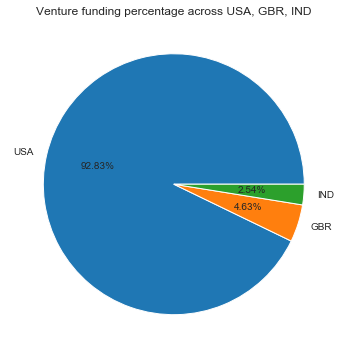

In [78]:
plt.figure(figsize=(6, 6))
plt.pie([107757097294.0, 5379078691.0, 2949543602.0], 
        labels=['USA', 'GBR', 'IND'],
        autopct='%.2f%%')
plt.title("Venture funding percentage across USA, GBR, IND")
plt.show() 

<h3> Companies which received most funding for Top 2 sectors in USA</h3>

**Details of the company which received highest funding in sector "Others":**

Based on total amount of funding received:

In [79]:
D1_cat1 = D1[D1['main_sector'] == D1_cat_table.index[0] ].groupby('company_permalink')['raised_amount_usd'].sum()
D1_cat1 = D1_cat1.sort_values(ascending = False)
D1_cat1.head()

company_permalink
/organization/virtustream           64300000.00
/organization/capella               54968051.00
/organization/airtight-networks     54201907.00
/organization/decarta               52100000.00
/organization/black-duck-software   51000000.00
Name: raised_amount_usd, dtype: float64

Based on total number of funding received:

In [80]:
D1_cat_num1 = D1[D1['main_sector'] == D1_cat_table.index[0] ].groupby('company_permalink')['raised_amount_usd'].count()
D1_cat_num1 = D1_cat_num1.sort_values(ascending = False)
D1_cat_num1.head()

company_permalink
/organization/capella                6
/organization/virtustream            6
/organization/black-duck-software    6
/organization/deliveryagent          5
/organization/bit9                   5
Name: raised_amount_usd, dtype: int64

Based on total funding amount as well as total count of funding /organization/virtustream is in top position:

In [81]:
print('Details of the Company which received highest investment in sector "Others" in USA: ')
print('Unique ID: ', D1_cat1.index[0])
print('Company Name: ', D1[D1.company_permalink == D1_cat1.index[0]].name.unique()[0])
print('Total investment: ', D1_cat1.iloc[0])

Details of the Company which received highest investment in sector "Others" in USA: 
Unique ID:  /organization/virtustream
Company Name:  Virtustream
Total investment:  64300000.0


**Details of the Company which received highest investment in sector Social, Finance, Analytics, Advertising in USA:**

Based on total amount of funding received:

In [82]:
D1_cat2 = D1[D1['main_sector'] == D1_cat_table.index[1] ].groupby('company_permalink')['raised_amount_usd'].sum()
D1_cat2 = D1_cat2.sort_values(ascending = False)
D1_cat2.head()

company_permalink
/organization/shotspotter   67933006.00
/organization/demandbase    63000000.00
/organization/intacct       61800000.00
/organization/netbase       60600000.00
/organization/lotame        59700000.00
Name: raised_amount_usd, dtype: float64

Based on total number of funding received:

In [83]:
D1_cat_num2 = D1[D1['main_sector'] == D1_cat_table.index[1] ].groupby('company_permalink')['raised_amount_usd'].count()
D1_cat_num2 = D1_cat_num2.sort_values(ascending = False)
D1_cat_num2.head()

company_permalink
/organization/shotspotter     7
/organization/netbase         7
/organization/choicestream    6
/organization/instamed        6
/organization/firstrain       6
Name: raised_amount_usd, dtype: int64

Based on total number as well as total funding raised, /organization/shotspotter is in top position. Let us print the details of /organization/shotspotter

In [84]:
print('Details of the Company which received highest investment in sector {} in USA: '.format(D1_cat_table.index[1]))
print('Unique ID: ', D1_cat2.index[0])
print('Company Name: ', D1[D1.company_permalink == D1_cat2.index[0]].name.unique()[0])
print('Total investment: ', D1_cat2.iloc[0])

Details of the Company which received highest investment in sector Social, Finance, Analytics, Advertising in USA: 
Unique ID:  /organization/shotspotter
Company Name:  SST Inc. (Formerly ShotSpotter)
Total investment:  67933006.0


<h3> Companies which received most funding for Top 2 sectors in GBR</h3>

**Details of the company which received highest funding in sector "Others":**

Based on the total amount of funding raised:

In [85]:
D2_cat1 = D2[D2['main_sector'] == D2_cat_table.index[0] ].groupby('company_permalink')['raised_amount_usd'].sum()
D2_cat1 = D2_cat1.sort_values(ascending = False)
D2_cat1.head()

company_permalink
/organization/electric-cloud            37000000.00
/organization/sensage                   36250000.00
/organization/enigmatic                 32500000.00
/organization/silverrail-technologies   29000000.00
/organization/opencloud                 27972766.00
Name: raised_amount_usd, dtype: float64

Based on total count of funding received:

In [86]:
D2_cat_num1 = D2[D2['main_sector'] == D2_cat_table.index[0] ].groupby('company_permalink')['raised_amount_usd'].count()
D2_cat_num1 = D2_cat_num1.sort_values(ascending = False)
D2_cat_num1.head()

company_permalink
/organization/sensage                    4
/organization/electric-cloud             4
/organization/opencloud                  3
/organization/enigmatic                  3
/organization/silverrail-technologies    3
Name: raised_amount_usd, dtype: int64

Based on total number as well as total funding raised, /organization/electric-cloud is in top position. Let us print the details of /organization/electric-cloud

In [87]:
print('Details of the Company which received highest investment in sector "Others" in GBR: ')
print('Unique ID: ', D2_cat1.index[0])
print('Company Name: ', D2[D2.company_permalink == D2_cat1.index[0]].name.unique()[0])
print('Total investment: ', D2_cat1.iloc[0])

Details of the Company which received highest investment in sector "Others" in GBR: 
Unique ID:  /organization/electric-cloud
Company Name:  Electric Cloud
Total investment:  37000000.0


**Details of the company which received highest funding in sector "sector Social, Finance, Analytics, Advertising":**

Based on total amount of fund raised:

In [88]:
D2_cat2 = D2[D2['main_sector'] == D2_cat_table.index[1] ].groupby('company_permalink')['raised_amount_usd'].sum()
D2_cat2 = D2_cat2.sort_values(ascending = False)
D2_cat2.head()

company_permalink
/organization/celltick-technologies   37500000.00
/organization/mythings                34000000.00
/organization/zopa                    32900000.00
/organization/imagini                 28550000.00
/organization/marketinvoice           25553007.00
Name: raised_amount_usd, dtype: float64

Based on total number of fund received:

In [89]:
D2_cat_num2 = D2[D2['main_sector'] == D2_cat_table.index[1] ].groupby('company_permalink')['raised_amount_usd'].count()
D2_cat_num2 = D2_cat_num2.sort_values(ascending = False)
D2_cat_num2.head()

company_permalink
/organization/celltick-technologies    4
/organization/mythings                 4
/organization/zopa                     3
/organization/victor                   3
/organization/amplience                3
Name: raised_amount_usd, dtype: int64

Based on total number as well as total funding raised, /organization/celltick-technologies is in top position. Will Print the details of /organization/celltick-technologies:

In [90]:
print('Details of the Company which received highest investment in sector {} in GBR: '.format(D2_cat_table.index[1]))
print('Unique ID: ', D2_cat2.index[0])
print('Company Name: ', D2[D2.company_permalink == D2_cat2.index[0]].name.unique()[0])
print('Total investment: ', D2_cat2.iloc[0])

Details of the Company which received highest investment in sector Social, Finance, Analytics, Advertising in GBR: 
Unique ID:  /organization/celltick-technologies
Company Name:  Celltick Technologies
Total investment:  37500000.0


<h3> Companies which received most funding for Top 2 sectors in IND</h3>

**Details of the company which received highest funding in sector "Others":**

Based on total amount of funding received:

In [91]:
D3_cat1 = D3[D3['main_sector'] == D3_cat_table.index[0] ].groupby('company_permalink')['raised_amount_usd'].sum()
D3_cat1 = D3_cat1.sort_values(ascending = False)
D3_cat1.head()

company_permalink
/organization/firstcry-com       39000000.00
/organization/myntra             38000000.00
/organization/commonfloor        32900000.00
/organization/pepperfry-com      28000000.00
/organization/itzcash-card-ltd   25000000.00
Name: raised_amount_usd, dtype: float64

Based on total number of funding received:

In [92]:
D3_cat_num1 = D3[D3['main_sector'] == D3_cat_table.index[0] ].groupby('company_permalink')['raised_amount_usd'].count()
D3_cat_num1 = D3_cat_num1.sort_values(ascending = False)
D3_cat_num1.head()

company_permalink
/organization/myntra           4
/organization/firstcry-com     3
/organization/pepperfry-com    3
/organization/commonfloor      3
/organization/limeroad         2
Name: raised_amount_usd, dtype: int64

Though mytra received more number of funding, fitsrcry received highest total funding. So will consider firstcry as top company:

    Assumption: Top company based on highest total funding

In [93]:
print('Details of the Company which received highest investment in sector "Others" in IND: ')
print('Unique ID: ', D3_cat1.index[0])
print('Company Name: ', D3[D3.company_permalink == D3_cat1.index[0]].name.unique()[0])
print('Total investment: ', D3_cat1.iloc[0])

Details of the Company which received highest investment in sector "Others" in IND: 
Unique ID:  /organization/firstcry-com
Company Name:  FirstCry.com
Total investment:  39000000.0


**Details of the company which received highest funding in sector "Social, Finance, Analytics, Advertising"**

Based on total amount of funding received:

In [94]:
D3_cat2 = D3[D3['main_sector'] == D3_cat_table.index[1] ].groupby('company_permalink')['raised_amount_usd'].sum()
D3_cat2 = D3_cat2.sort_values(ascending = False)
D3_cat2.head()

company_permalink
/organization/manthan-systems              50700000.00
/organization/komli-media                  28000000.00
/organization/shopclues-com                25000000.00
/organization/intarvo                      21900000.00
/organization/grameen-financial-services   21556050.00
Name: raised_amount_usd, dtype: float64

Based on total number of funding received:

In [95]:
D3_cat_num2 = D3[D3['main_sector'] == D3_cat_table.index[1] ].groupby('company_permalink')['raised_amount_usd'].count()
D3_cat_num2 = D3_cat_num2.sort_values(ascending = False)
D3_cat_num2.head()

company_permalink
/organization/manthan-systems               4
/organization/komli-media                   3
/organization/microland                     2
/organization/grameen-financial-services    2
/organization/shopclues-com                 2
Name: raised_amount_usd, dtype: int64

Based on total amount as well as total number '/organization/manthan-systems' is the clear winner. Will print the details of /organization/manthan-systems.

In [96]:
print('Details of the Company which received highest investment in sector {} in IND: '.format(D3_cat_table.index[1]))
print('Unique ID: ', D3_cat2.index[0])
print('Company Name: ', D3[D3.company_permalink == D3_cat2.index[0]].name.unique()[0])
print('Total investment: ', D3_cat2.iloc[0])

Details of the Company which received highest investment in sector Social, Finance, Analytics, Advertising in IND: 
Unique ID:  /organization/manthan-systems
Company Name:  Manthan Systems
Total investment:  50700000.0


<h3> Percentage of funding received by top 3 sectors in USA, GBR, IND</h3>

NOTE: For the percentage computation only considering the funding received for top 3 sectors to see in what percentage each sector received funding. So that Spark Fund can follow this trend for funding across these sectors

**Percentage of funding received by Top 3 sector in USA**

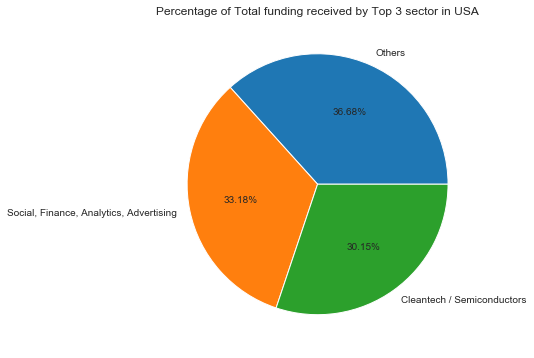

In [97]:
#For this we will make use of D1_cat_table which contains total fund raised and total number of funds per sector for USA
plt.figure(figsize=(6, 6))
plt.pie(D1_cat_table[:3].total_amount_invested.values, 
        labels=list(D1_cat_table.index[:3]),
        autopct='%.2f%%')
plt.title("Percentage of Total funding received by Top 3 sector in USA")
plt.show() 

**Percentage of Total funding received by Top 3 sector in GBR**

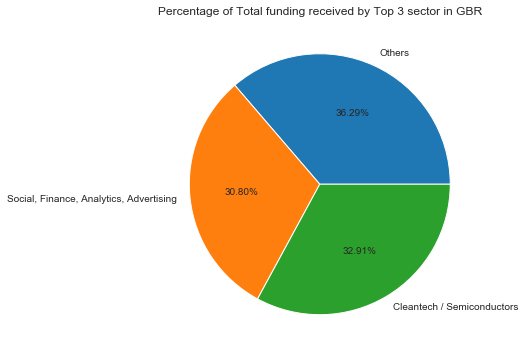

In [98]:
#For this we will make use of D2_cat_table which contains total fund raised and total number of funds per sector for GBR
plt.figure(figsize=(6, 6))
plt.pie(D2_cat_table[:3].total_amount_invested.values, 
        labels=list(D2_cat_table.index[:3]),
        autopct='%.2f%%')
plt.title("Percentage of Total funding received by Top 3 sector in GBR")
plt.show() 

**Percentage of Total funding received by Top 3 sector in IND**

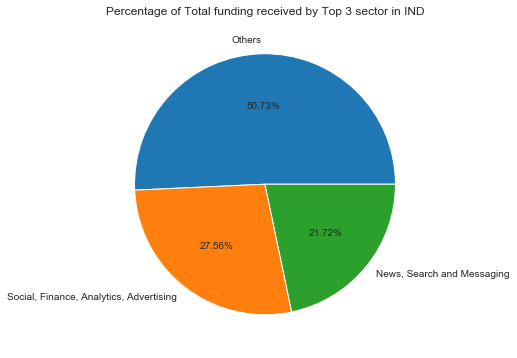

In [99]:
#For this we will make use of D3_cat_table which contains total fund raised and total number of funds per sector for IND
plt.figure(figsize=(6, 6))
plt.pie(D3_cat_table[:3].total_amount_invested.values, 
        labels=list(D3_cat_table.index[:3]),
        autopct='%.2f%%')
plt.title("Percentage of Total funding received by Top 3 sector in IND")
plt.show() 

<h2>Visualization of Funding Round Type Analysis based on Avergae Funding</h2>

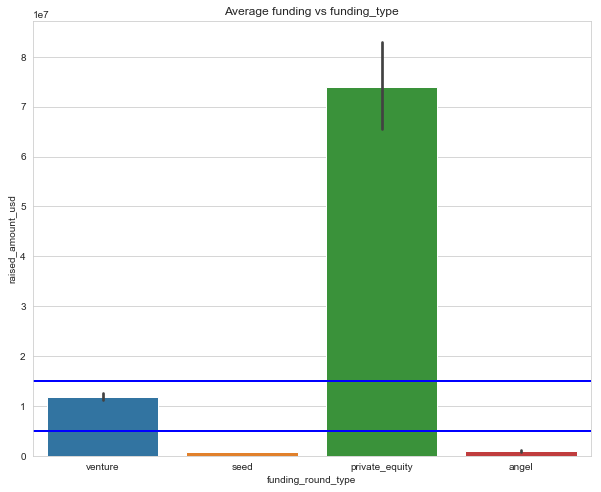

In [100]:
plt.figure(figsize=(10, 8))

sns.barplot(y='raised_amount_usd', x="funding_round_type", data=master_frame, estimator=(np.mean))
plt.title("Average funding vs funding_type")
plt.axhline(y = 5000000, linewidth=2, color='b')
plt.axhline(y = 15000000, linewidth=2, color='b')
plt.show()

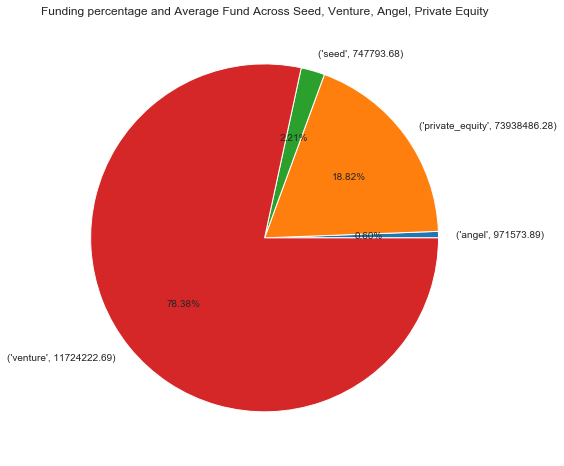

In [101]:
fundtype_DF = master_frame.groupby('funding_round_type')['raised_amount_usd'].agg([np.mean, sum])

#fundtype_DF = fundtype_DF[fundtype_DF.index != 'angel']

labels = []
for i, data in fundtype_DF.iterrows():
    labels.append((i,round(data['mean'], 2)))
plt.figure(figsize=(8, 8))
plt.pie(fundtype_DF['sum'].values, labels= labels, autopct='%.2f%%')
plt.title("Funding percentage and Average Fund Across Seed, Venture, Angel, Private Equity")
plt.show() 

<h2>Visualization of Top 9 Countries Based on Total Funding</h2>

**Let's arrange this plot in the descending order for easier understanding**

In [102]:
result = top9.groupby('country_code')['raised_amount_usd'].aggregate(np.sum)
result = result.sort_values(ascending = False)

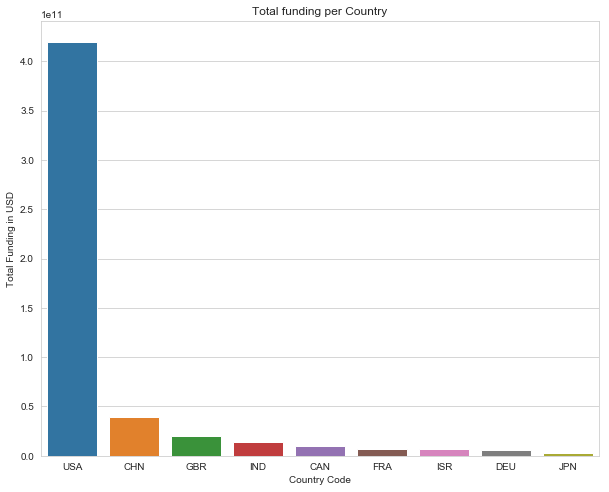

In [103]:
plt.figure(figsize=(10, 8))
sns.barplot(y=result.values, x= result.index)
plt.xlabel('Country Code')
plt.ylabel('Total Funding in USD')
plt.title("Total funding per Country")
plt.show() 

In [104]:
Top3DF = pd.concat([D1, D2, D3], axis = 0)
Top3DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13012 entries, 0 to 327
Data columns (total 8 columns):
company_permalink             13012 non-null object
raised_amount_usd             13012 non-null float64
name                          13012 non-null object
country_code                  13012 non-null object
primary_sector                13012 non-null object
main_sector                   13012 non-null object
total_number_of_investment    13012 non-null int64
total_amount_invested         13012 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 914.9+ KB


<h2> Number of Fundings received per Top 3 Sectors for Top 3 English Speaking Countries </h2>

**Number of funding received by top 3 english speaking contries across all sectors**

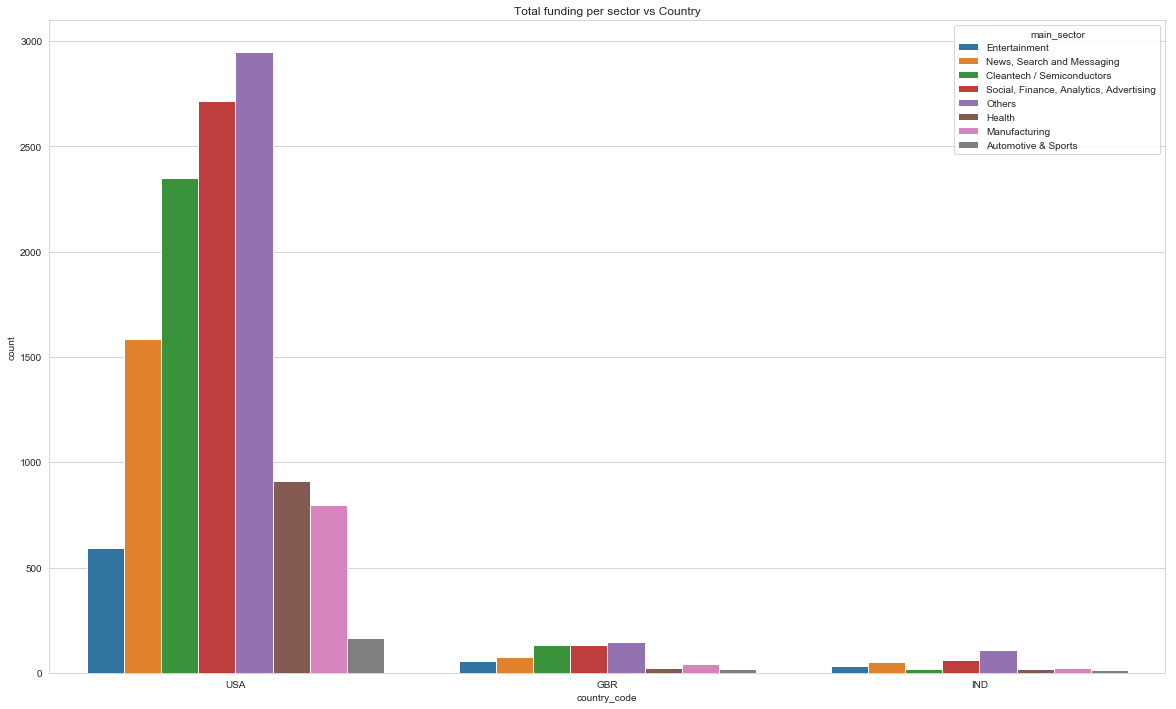

In [105]:
plt.figure(figsize=(20, 12))

sns.countplot( x="country_code", hue = 'main_sector', data=Top3DF)
plt.title("Total funding per sector vs Country")
plt.show()

**Number of funding received by top 3 english speaking contries across top 3 sectors**

In [106]:
Top3DFtest = Top3DF[((Top3DF.country_code == 'USA') & Top3DF.main_sector.isin([D1_cat_table.index[0], D1_cat_table.index[1], D1_cat_table.index[2]])) |
                    ((Top3DF.country_code == 'GBR') & Top3DF.main_sector.isin([D2_cat_table.index[0], D2_cat_table.index[1], D2_cat_table.index[2]])) |
                    ((Top3DF.country_code == 'IND') & Top3DF.main_sector.isin([D3_cat_table.index[0], D3_cat_table.index[1], D3_cat_table.index[2]]))]
Top3DFtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8646 entries, 2174 to 274
Data columns (total 8 columns):
company_permalink             8646 non-null object
raised_amount_usd             8646 non-null float64
name                          8646 non-null object
country_code                  8646 non-null object
primary_sector                8646 non-null object
main_sector                   8646 non-null object
total_number_of_investment    8646 non-null int64
total_amount_invested         8646 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 607.9+ KB


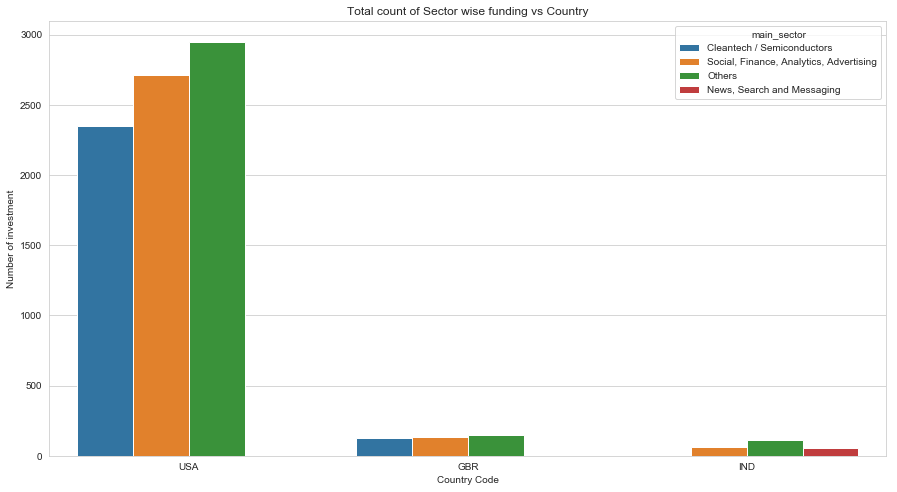

In [98]:
plt.figure(figsize=(15, 8))

sns.countplot( x="country_code", hue = 'main_sector', data=Top3DFtest)
plt.ylabel('Number of investment')
plt.xlabel('Country Code')
plt.title("Total count of Sector wise funding vs Country")
plt.show()